# Marching Squares
Takes a scalar field such as the Signed Distance Function (SDF) and generates contours consisting of line segment. A similar algorithm exists in 3D where a scalar field is turned into surfaces consisting of triangles.

In [2]:
import numpy as np

In [34]:
import seaborn as sns
sns.set_theme()
sns.set(style='darkgrid', context='talk', palette='Pastel1')
sns.set(style='dark')  # get rid of gridlines

In [35]:
# configure matlab for notebooks
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 5]

In [36]:
# load points cloud from the field interpolation
sdf = np.load('sdf-512-16.00.npy')

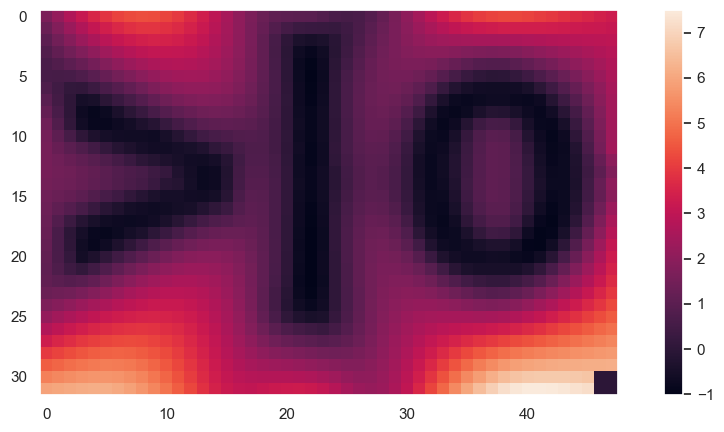

In [37]:
plt.imshow(sdf); plt.colorbar()

(0.0, 47.0, 0.0, 31.0)

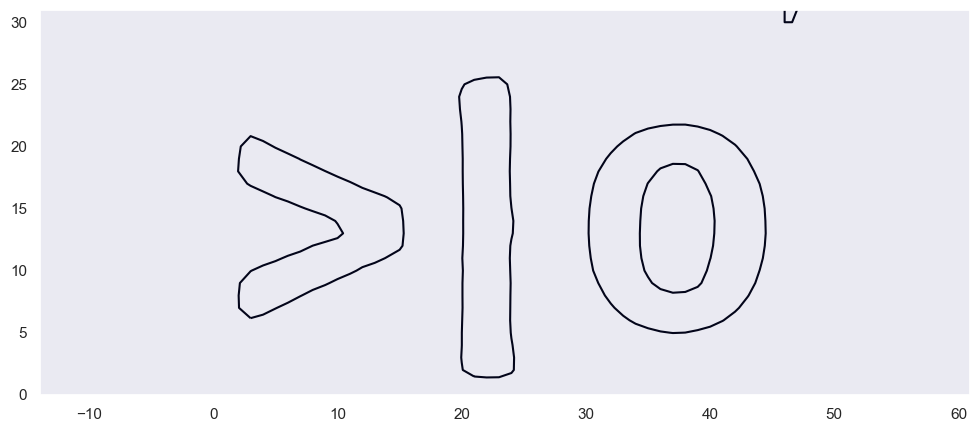

In [38]:
plt.contour(sdf, levels=[0]); plt.axis('equal')

## Algorithm
* Each 2x2 block of the SDF is iterated
* Each block is thresholded against the level (e.g. 0) as either below or not below.
* There are 16 (2^4) different configurations each yielding a specific set of lines (or no line) cutting the square
* The exact vertex positions of the lines are computed by lineary interpolating the positions

In [80]:
# TODO: Zoom in on single 2x2 block

In [205]:
# 0 -- 1
# |    |
# 2 -- 3

LOOKUP = [
    (),
    (((0, 2), (0, 1)),),
    (((0, 1), (1, 3)),),
    (((0, 2), (1, 3)),),
    (((0, 2), (2, 3)),),
    (((0, 1), (2, 3)),),
    (((0, 2), (2, 3)), ((0, 1), (1, 3))),
    (((2, 3), (1, 3)),),
    (((1, 3), (2, 3)),),
    (((0, 2), (0, 1)), ((2, 3), (1, 3))),
    (((2, 3), (0, 1)),),
    (((2, 3), (0, 2)),),
    (((1, 3), (0, 2)),),
    (((1, 3), (0, 1)),),
    (((1, 3), (0, 1)),),
    (),    
]


In [195]:
from typing import List
Edge = Tuple[int, int]
def interpolate_edge(points: np.ndarray, edge: Edge):
    i0, i1 = edge
    return (points[i0] + points[i1]) * 0.5

def interpolate_cut(points: np.ndarray, cut: Tuple[Edge, Edge]):
    e0, e1 = cut
    return interpolate_edge(points, e0), interpolate_edge(points, e1)

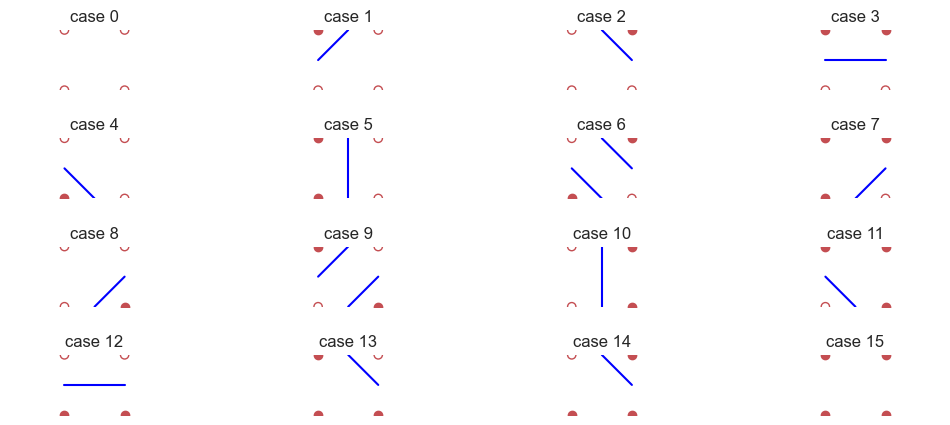

In [214]:
def to_bits(number: int, n: int) -> np.ndarray:
    return np.array([bool(number & (1 << i)) for i in range(n)], dtype=bool)

points = np.array([
    (0, 0),
    (1, 0),
    (0, 1),
    (1, 1),
])
fig, axes = plt.subplots(4, 4)
plt.subplots_adjust(wspace=0.5, hspace=0.8)

for i in range(16):
    row, column = i // 4, i % 4
    plot = axes[row, column]
    plot.set_title(f'case {i}')
    plot.axis('off')
    plot.axis('equal')
    plot.axis([0, 1, 1, 0])

    bits = to_bits(i, n=4)
    plot.scatter(points[bits, 0], points[bits, 1], facecolors='r', edgecolors='r')
    plot.scatter(points[~bits, 0], points[~bits, 1], facecolors='none', edgecolors='r')
    for cut in LOOKUP[i]:
        a, b = interpolate_cut(points, cut)
        plot.plot([a[0], b[0]], [a[1], b[1]], color='blue')

In [218]:
from typing import Tuple


def marching_squares(sdf: np.ndarray, level: float = .0) -> Tuple[np.ndarray, np.ndarray]:
    h, w = sdf.shape
    vertices = []
    lines = []
    for y in range(h - 1):
        for x in range(w - 1):
            block = (
                sdf[y, x] < level,
                sdf[y, x + 1] < level,
                sdf[y + 1, x] < level,
                sdf[y + 1, x + 1] < level,
            )
            index = sum(int(bit) * 1 << i for i, bit in enumerate(block))
            p = np.array([x, y])
            for cut in LOOKUP[index]:
                a, b = interpolate_cut(points, cut)
                lines.append((len(vertices), len(vertices) + 1))
                vertices.extend([p + a, p + b])

    return np.vstack(vertices), lines

vertices, lines = marching_squares(sdf)